# 2D elliptic interface problem with circular interface 
[Yanan Xing, Lina Song, Xiaoming He, Changxin Qiu]

In this example we consider the 2D elliptic interface problem with circular interface $\Gamma$,

$$\Gamma = \lbrace (x,y) | x^2 + y^2 = r_0^2  \rbrace$$

Let de domain $\Omega=[-1,1]\times[-1,1]$, where $\Omega^{-}$ is the part of $\Omega$ that's inside the closed interface $\Gamma$, and $\Omega^{+} = \Omega / (\Omega^{-} \cup\Gamma)$.

Let

$$
\beta \left\lbrace \begin{matrix}
 10, (x,y)\in \Omega^+\\
 1,  (x,y)\in \Omega^-
 \end{matrix} \right.
$$

and the jump conditions on $\Gamma$ are

$$[u]_\Gamma = 0 $$

$$\left[\beta \frac{\partial u}{\partial n_\Gamma}\right]_\Gamma  = 5 (\beta^+ - \beta^-)\frac{(x^2 + y^2)^{5/2}}{r_0}$$

The exact solution is

$$u(x,y) = \frac{(x^2+y^2)^{5/2}}{\beta^-}$$

where $r_0=\pi/6.28$. Substitution of $u(x,y)$ into $-\nabla\cdot(\beta\nabla u) = f$ defines the source term $f$.

## Importing needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# calfem-python
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv

## Creating Geometry

In [2]:
geometry = cfg.Geometry()

### Points

#### Square domain

In [3]:
geometry.point([-1,-1])    # 0
geometry.point([1,-1])     # 1
geometry.point([1,1])      # 2
geometry.point([-1,1])     # 3

#### Circualr interface

In [4]:
delta = 0.001
r0 = np.pi / 6.28

# Interface minus
r0_m = r0 - delta
geometry.point([r0_m,0])     # 4
geometry.point([0,r0_m])     # 5
geometry.point([-r0_m,0])    # 6
geometry.point([0,-r0_m])    # 7

# Interface plus
r0_p = r0 + delta
geometry.point([r0_p,0])     # 8
geometry.point([0,r0_p])     # 9
geometry.point([-r0_p,0])    # 10
geometry.point([0,-r0_p])    # 11

# center
geometry.point([0,0])      # 12

### Lines

#### Square domain

In [5]:
dirichlet = 10
geometry.spline([0,1], marker=dirichlet)     # 0
geometry.spline([1,2], marker=dirichlet)     # 1
geometry.spline([2,3], marker=dirichlet)     # 2
geometry.spline([3,0], marker=dirichlet)     # 3

#### Circular interfce

In [6]:
interfaceA = 11
interfaceB = 12

# interface minus
geometry.circle([4,12,5], marker=interfaceA)    # 4
geometry.circle([5,12,6], marker=interfaceA)    # 5
geometry.circle([6,12,7], marker=interfaceA)    # 6
geometry.circle([7,12,4], marker=interfaceA)    # 7

# interface plus
geometry.circle([8,12,9], marker=interfaceB)    # 8
geometry.circle([9,12,10], marker=interfaceB)   # 9
geometry.circle([10,12,11], marker=interfaceB)  # 10
geometry.circle([11,12,8], marker=interfaceB)   # 11


### Surfaces

In [7]:
mat_minus = 1
mat_plus = 2
geometry.surface([4,5,6,7], marker=mat_minus)                   # 0
geometry.surface([0,1,2,3], [[8,9,10,11]], marker=mat_plus)     # 1

### Geometry Plot

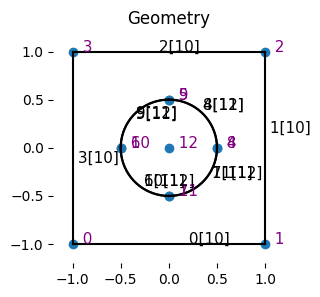

In [8]:
geometry_plot = cfv.figure(fig_size=(3,3))
cfv.title('Geometry')
cfv.draw_geometry(geometry)
plt.show()

## Creating Mesh

In [82]:
mesh = cfm.GmshMesh(geometry)

mesh.el_type = 2                            # type of element: 2 = triangle
mesh.dofs_per_node = 1
mesh.el_size_factor = 0.08

coords, edof, dofs, bdofs, elementmarkers = mesh.create()   # create the geometry
verts, faces, vertices_per_face, is_3d = cfv.ce2vf(
    coords,
    edof,
    mesh.dofs_per_node,
    mesh.el_type
)

Info    : GMSH -> Python-module


### Mesh plot

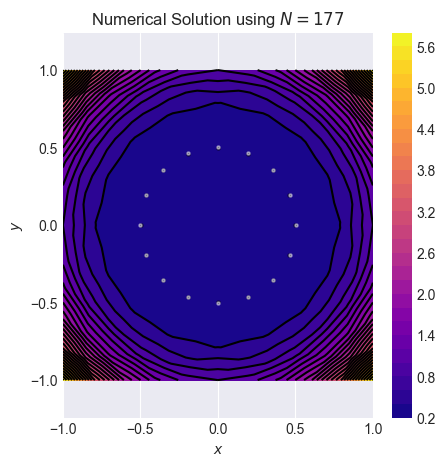

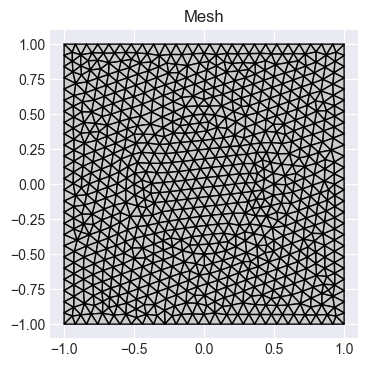

In [83]:
mesh_plot = cfv.figure(fig_size=(8,4))
cfv.title('Mesh')
cfv.draw_mesh(coords=coords, edof=edof, dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, filled=True)
plt.show()

## Nodes indexing separated by boundary conditions

In [84]:
# Dirichlet nodes
bd = np.asarray(bdofs[dirichlet]) - 1

# Interface nodes
biA = np.asarray(bdofs[interfaceA]) - 1
biB = np.asarray(bdofs[interfaceB]) - 1

# Interior nodes
elementmarkers = np.asarray(elementmarkers)
B = np.hstack((bd, biA, biB))

m_minus = faces[elementmarkers == mat_minus]
m_minus = m_minus.flatten()
m_minus = np.setdiff1d(m_minus,B)

m_plus = faces[elementmarkers == mat_plus]
m_plus = m_plus.flatten()
m_plus = np.setdiff1d(m_plus,B)

#### Nodes by color plot

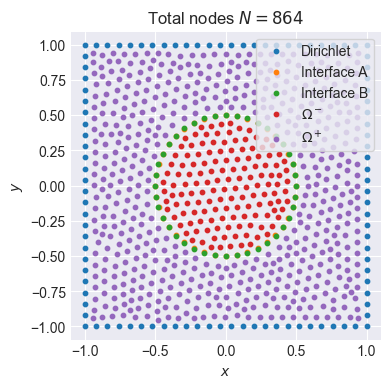

In [85]:
plt.style.use(["seaborn-v0_8-darkgrid"])
plt.rcParams["legend.frameon"] = True
# plt.rcParams["legend.shadow"] = True

from plots import plot_nodes
nodes_by_color_plot = plot_nodes(
    p=coords,
    b=(
       bd,
       biA,
       biB,
       m_minus,
       m_plus
    ),
    labels=(
        "Dirichlet",
        "Interface A",
        "Interface B",
        "$\Omega^-$",
        "$\Omega^+$"
    ),
    figsize=(4,4),
    size=10,
    alpha = 1,
    loc="best",
    nums=False,
    title="Total nodes $N = " + str(coords.shape[0]) + "$"
)
plt.show()

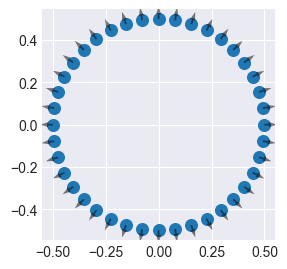

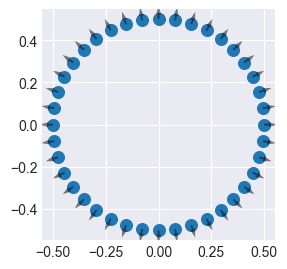

In [86]:
from plots import plot_normal_vectors
plot_normal_vectors(biA, coords, figsize=(3,3))
plot_normal_vectors(biB, coords, figsize=(3,3))
plt.show()

## Problem parameters

In [136]:
L = np.array([0,0,0,1,0,1])

beta_m = lambda p: 1
beta_p = lambda p: 10

fd = lambda p: ((p[0]**2 + p[1]**2)**(5/2))/beta_m(p)

# jump conditions
u_n_jump = lambda p: - 5 * (10-9) * ((p[0]**2 + p[1]**2)**(5/2))/r0
u_jump = lambda p: 0

where $L$ is the coeficients vector:

$$
L = 
\begin{bmatrix}
A \\
B \\
C \\
D \\
E \\
F \\
\end{bmatrix}
$$

given by the lineal differential operator $\mathbb{L}$ that is meant to be approximated using GFDM:

$$
\mathbb{L}u =
A u
+ B \frac{\partial u}{\partial x}
+ C \frac{\partial u}{\partial y}
+ D \frac{\partial^2 u}{\partial x^2}
+ E \frac{\partial^2 u}{\partial y^2}
+ F \frac{\partial^2 u}{\partial x \partial y}
$$

Source from $-\nabla \cdot (\beta \nabla u) = f$

$$ f = \frac{\beta}{\beta^-} 25 (x^2 + y^2)^{3/2} $$

In [137]:
def beta(p):
    dist = np.sqrt(p[0]**2 + p[1]**2)
    if dist < r0:
        value = beta_m(p)
    else:
        value = beta_p(p)
    
    return value

def source(p):
    return 25 * beta(p) / beta_m(p) * (p[0]**2 + p[1]**2)**(3/2)

In [138]:
materials = {}
materials['material_minus'] = [beta_m, m_minus]
materials['material_plus'] = [beta_p, m_plus]

neumann_boundaries = {}

dirichlet_boundaries = {}
dirichlet_boundaries["square"] = [bd, fd]

interfaces = {}
interfaces["interface0"] = [beta_m, beta_p, biA, biB, u_n_jump, u_jump, m_minus, m_minus]

## Assembling and Solving system $KU=F$

In [139]:
from GFDMI import create_system_K_F
K,F,U,p = create_system_K_F(
    p=coords,
    triangles=faces,
    L=L,
    source=source,
    materials=materials,
    neumann_boundaries=neumann_boundaries,
    dirichlet_boundaries=dirichlet_boundaries,
    interfaces = interfaces
)

### Solution plot

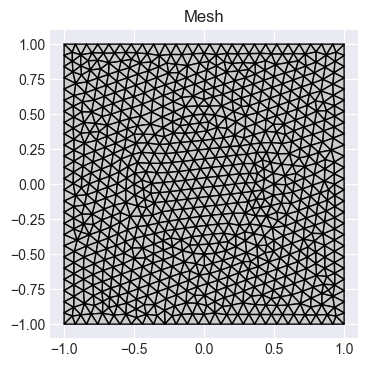

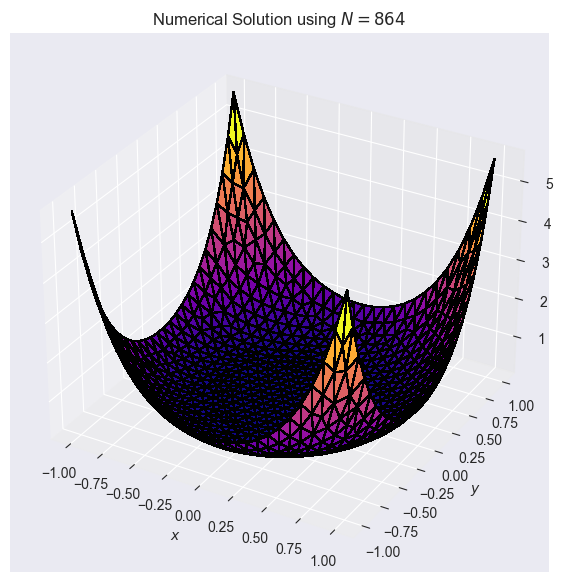

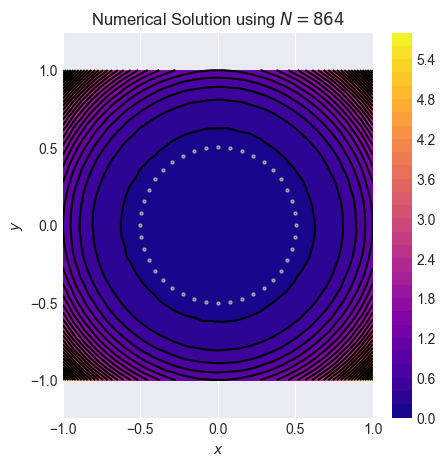

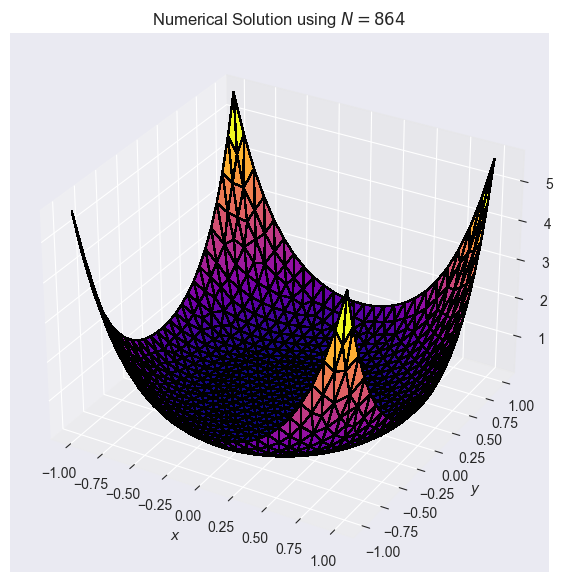

In [140]:
from plots import tri_surface
solution_3d, _ = tri_surface(
    p=p,
    t=faces,
    U=U,
    title="Numerical Solution using $N = "+ str(coords.shape[0])+"$",
    alpha=1,
    azim=-60,
    elev=30,
    edgecolor="k",
    figsize=(7,7)
)
plt.show()

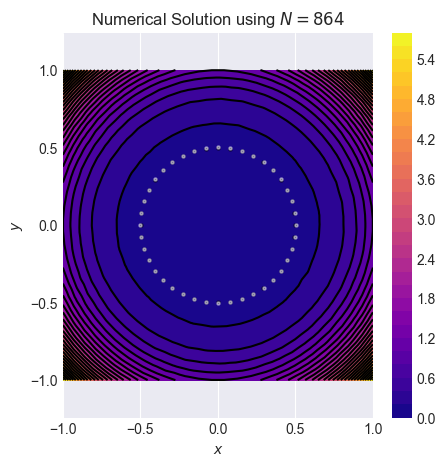

In [141]:
from plots import contourf_plot
solution_contourf = contourf_plot(p=p, U=U, levels=30, title="Numerical Solution using $N = "+ str(coords.shape[0])+"$", figsize=(5,5))
plt.tricontour(p[:,0], p[:,1], U, colors="k", levels=30)
plt.scatter(coords[biA,0], coords[biA,1], alpha=0.45, s=5, color="black")
plt.scatter(coords[biB,0], coords[biB,1], alpha=0.45, s=5, color="white")
plt.show()

## Exact solution

The exact solution is

$$u(x,y) = \frac{(x^2+y^2)^{5/2}}{\beta^-}$$

In [142]:
def exact(p):
    return 1 / beta_m(p) * (p[0]**2 + p[1]**2)**(5/2)

Uex = np.zeros(p.shape[0])
for i in range(Uex.shape[0]):
    Uex[i] = exact(p[i])

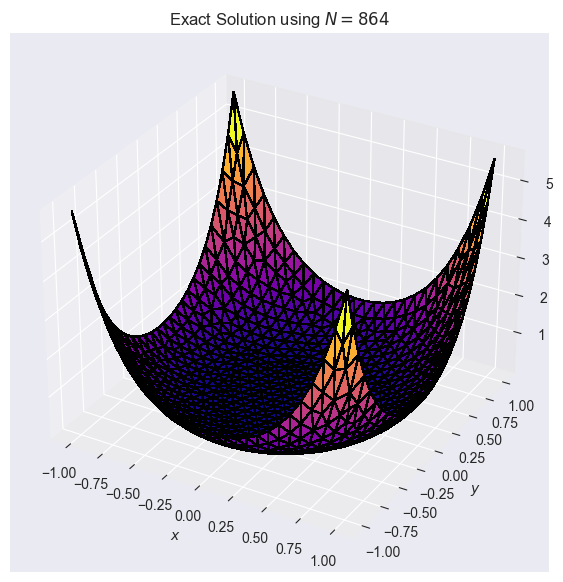

In [143]:
tri_surface(
    p,
    faces,
    Uex,
    figsize=(7,7),
    edgecolor="k",
    title="Exact Solution using $N = "+ str(coords.shape[0])+"$",
)
plt.show()

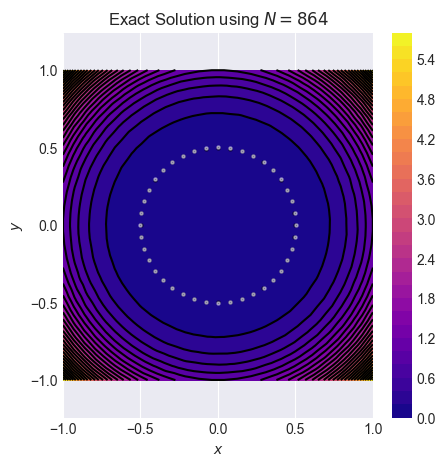

In [144]:
contourf_plot(p=p, U=Uex, levels=30, title="Exact Solution using $N = "+ str(coords.shape[0])+"$", figsize=(5,5))
plt.tricontour(p[:,0], p[:,1], Uex, colors="k", levels=30)
plt.scatter(coords[biA,0], coords[biA,1], alpha=0.45, s=5, color="black")
plt.scatter(coords[biB,0], coords[biB,1], alpha=0.45, s=5, color="white")
plt.show()

In [145]:
def RMSE(U, Uex):
    return np.sqrt(
    np.mean(
        (U - Uex)**2
    )
)
RMSE(U, Uex)

0.07356428952579545

In [146]:
# [mesh.el_size_factor, total_nodes, RMSE]
nodes_error = np.array([
    [0.50,  48,  0.3856034042673103],
    [0.30, 101,  0.24625039139681926],
    [0.20, 177,  0.13019187591372677],
    [0.14, 338,  0.10887634683592147],
    [0.12, 430,  0.10159202915541635],
    [0.10, 575,  0.09443671477592522],
    [0.08, 864,  0.08948872719782641],
    [0.06, 1586, 0.08570815786044138],
    [0.04, 3212, 0.08217217631716535]
])

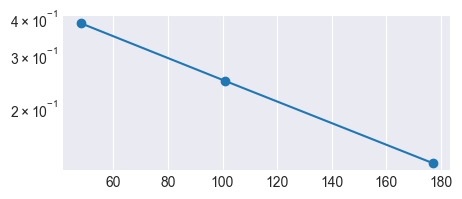

In [147]:
plt.figure(figsize=(5,2))
ax = plt.axes()
ax.semilogy(nodes_error[:3,1], nodes_error[:3,2], 'o-')
plt.show()

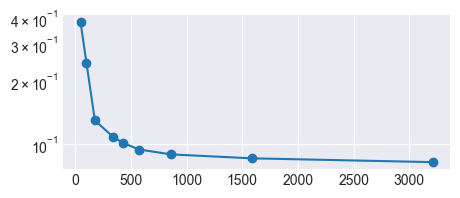

In [148]:
plt.figure(figsize=(5,2))
ax = plt.axes()
ax.semilogy(nodes_error[:,1], nodes_error[:,2], 'o-')
plt.show()

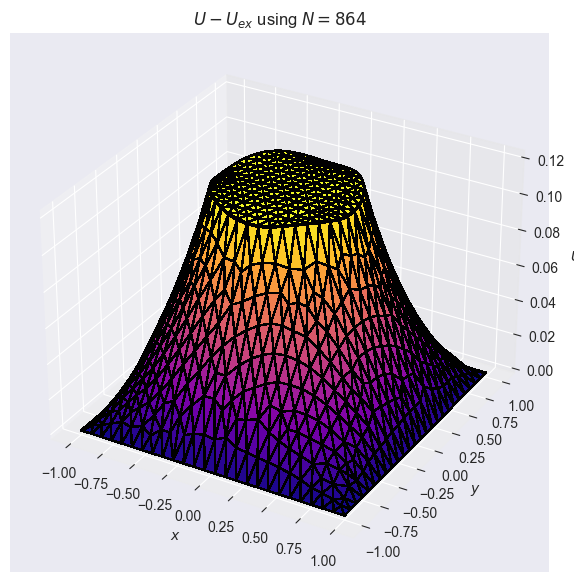

In [149]:
tri_surface(
    p,
    faces,
    U-Uex,
    figsize=(7,7),
    edgecolor="k",
    title="$U-U_{ex}$ using $N = "+ str(coords.shape[0])+"$",
)
plt.show()

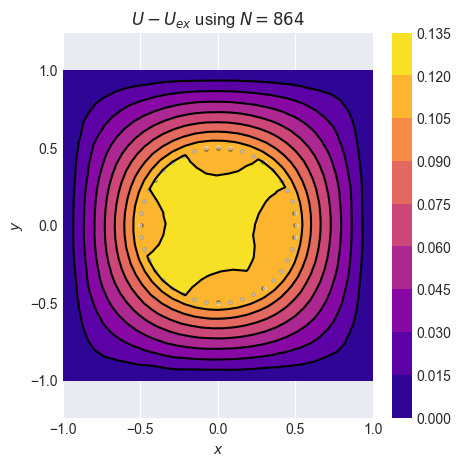

In [150]:
contourf_plot(p=p, U=U-Uex, levels=10, title="$U-U_{ex}$ using $N = "+ str(coords.shape[0])+"$", figsize=(5,5))
plt.tricontour(p[:,0], p[:,1], U-Uex, colors="k", levels=10)
plt.scatter(coords[biA,0], coords[biA,1], alpha=0.45, s=5, color="black")
plt.scatter(coords[biB,0], coords[biB,1], alpha=0.45, s=5, color="white")
plt.show()

## Saving all figures

In [151]:
plt.figure(geometry_plot)
plt.savefig(r'figures\ex02\geometry.png', dpi=400)
plt.figure(mesh_plot)
plt.savefig(r'figures\ex02\mesh.png', dpi=400)
plt.figure(nodes_by_color_plot)
plt.savefig(r'figures\ex02\nodes.png', dpi=400)
plt.figure(solution_3d)
plt.savefig(r'figures\ex02\sol_3d.png', dpi=400)
plt.figure(solution_contourf)
plt.savefig(r'figures\ex02\sol_contourf.png', dpi=400)